# Ising Model 
For a graph, $G = (E,V)$, defined by a set of edges, $E$, and vertices, $V$, we want to represent an Ising model, where the edge weights, $w_{ij}$ are given by the spin interactions, i.e., $w_{ij} = J_{ij}$.

Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H} = \sum_{(i,j)\in E}J_{ij} s_is_j$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the sumation runs over all edges in the graph. 
**Note:** As we saw before, this Hamiltonian operator is simple, in that a single `BitString` returns a single energy. This is because the matrix representation of the Hamiltonian operator in the computational basis (i.e., basis of all possible `BitString`'s) is a diagonal matrix. However, most quantum mechanical Hamiltonians will not be diagonal, and in that case applying $H$ to a single `BitString` would generate multiple `BitString`'s.   



# Thermodynamic averages
In the previous notebook, we used the Hamiltonian (which was defined as a graph) to find the lowest "energy" configuration (`BitString`). However, often times we want to compute average values of an observable over all possible configurations. Imagine that you have a bag containing some mixture of `BitString`'s. If we reach into the back and pull out a `BitString` at random, the probability of observing the specific `BitString` $\ket{\alpha}$ will be denoted as $P(\alpha)$. Each possible `BitString` has its own probability. 

Given this situation, what is the average energy in the bag? To answer this, we could just pull out each `BitString`, measure it's energy, add them all up, and divide by the total number of `BitString`s. Or if we knew the probabilty of observing each possible `BitString`, we could equivalently, add up the probabilities times the energy, $E(\alpha)$, of each possible `BitString`:
$$
\left<E\right> = \sum_\alpha P(\alpha)E(\alpha)
$$ 
In this sense, the average energy (or any average quantity) depends on the given probability distribution in the bag. 

While there are an infinite number of possible probability distributions one might interact with, a very common distribution (and the one we will focus on) is the `Gibbs Distribution`, also called the `Boltzmann Distribution`:
$$
P(\alpha) = \frac{e^{-\beta E(\alpha)}}{Z} = \frac{e^{-\beta E(\alpha)}}{\sum_{\alpha'}e^{-\beta E(\alpha')}}
$$
where $\beta$ sometimes has a physical meaning of $\beta = 1/kT$, where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$ and $T$ is the temperature in Kelvin. We generally refer to the normalization constant $Z$ as the partition function. 

This expression, defines the probability of observing a particular configuration of spins, $\alpha$. As you can see, the probability of pulling $\alpha$ out of your bag decays exponentially with increasing energy of $\alpha$, $E(\alpha)$. This expression governs the behavior of the vast majority of physical systems, meaning that in nature at low temperatures, one typically expects to observe the lowest possible configuration of a system.

If the population (e.g., the bag of `BitString`s) is known to form a Boltzmann distribution, the expectation value of any quantity, `A`, can be defined as:
$$
\left<A\right> = \frac{\sum_\alpha e^{-\beta E(\alpha)}A(\alpha)}{Z}.
$$

# Properties

For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to exactly obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases.

The expectation values we will compute in this notebook are
\begin{align}
\text{Energy} &= \left<E\right> \\
\text{Magnetization} &= \left<M\right> \\
\text{Heat Capacity} &= \left(\left<E^2\right>-\left<E\right>^2\right)T^{-2} \\
\text{Magnetic Susceptibility} &= \left(\left<M^2\right>-\left<M\right>^2\right)T^{-1}
\end{align}

# Expectation values for Boltzmann Distribution

In this notebook, we will write code to compute the expectation values of a few different properties, at a given temperature. We will then see how these change with temperature. 

## Load packages

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
random.seed(2)

## Create a graph that defines the Ising interactions

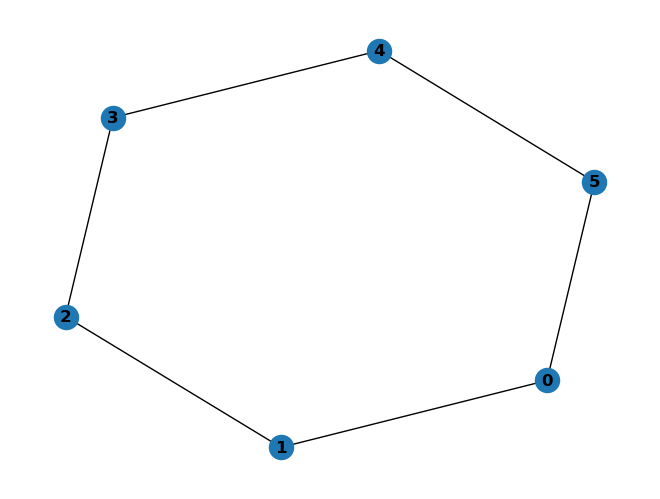

In [5]:
N = 6
Jval = 2.0
G = nx.Graph()
G.add_nodes_from([i for i in range(N)])
G.add_edges_from([(i,(i+1)% G.number_of_nodes() ) for i in range(N)])
for e in G.edges:
    G.edges[e]['weight'] = Jval

# Now Draw the graph. 
plt.figure(1)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

## Add your BitString class here:

In [9]:
class BitString:
    """
    Simple class to implement a config of bits
    """
    def __init__(self, N):
        self.N = N
        self.config = np.zeros(N, dtype=int)

    def __repr__(self):
        pass

    def __eq__(self, other):
        if other is None :
            return False
        if type(self) != type(other) :
            return False
        if self.N != other.N :
            return False              
        return np.array_equal(self.config, other.config)


    
    def __len__(self):
        return self.N

    def on(self):
        return self.config.sum()

    
    def off(self):
        return self.N - self.config.sum()
    
    def flip_site(self,i):
        self.config[i] = (self.config[i] + 1) % 2 
    
    def int(self):
        num = 0
        for i, bit in enumerate(reversed(self.config)):
            num += bit * (2 ** i)
        return num

    def set_config(self, s:list[int]):
        for i, bit in enumerate(s):
            self.config[i + (self.N - len(s))] = bit
        
    def set_int_config(self, dec:int):        
        for i in range(len(self.config)):
            self.config[i] = dec % 2
            dec //= 2
        self.config = self.config[::-1]
        



    def __str__(self):
        builder = ""
        for bit in self.config:
            builder += str(bit)
        return builder


## Write your energy function here:

In [10]:
def energy(bs: BitString, G: nx.Graph):
    """Compute energy of configuration, `bs`

        .. math::
            E = \\left<\\hat{H}\\right>

    Parameters
    ----------
    bs   : Bitstring
        input configuration
    G    : Graph
        input graph defining the Hamiltonian
    Returns
    -------
    energy  : float
        Energy of the input configuration
"""
def energy(bs: BitString, G: nx.Graph):
    energy = 0.0
    for u,v in G.edges():
        if bs.config[u] == bs.config[v]:
            energy += G.edges[u,v]["weight"]
        else:
            energy -= G.edges[u,v]["weight"]
    return energy


## Write function to compute the thermodynamic averages

In [46]:
k =  1
def compute_average_values(bs:BitString, G: nx.Graph, T: float):
    """
    Compute the average value of Energy, Magnetization, 
    Heat Capacity, and Magnetic Susceptibility 

        .. math::
            E = \\left<\\hat{H}\\right>

    Parameters
    ----------
    bs   : Bitstring
        input configuration
    G    : Graph
        input graph defining the Hamiltonian
    T    : float
        temperature of the system
    Returns
    -------
    energy  : float
    magnetization  : float
    heat capacity  : float
    magnetic susceptibility  : float
    """
    E = 0
    M = 0
    HC = 0
    MS = 0

    z, z2, zm, zm2 = boltzmanDenominator(bs, G, T)
    for i in range(2 ** bs.N):
        bs.set_int_config(i)
        currEnergy = energy(bs, G)
        p = np.e ** ((-1 / (k * T))* currEnergy)
        p /= z
        E += currEnergy*p
        currEnergySquared = currEnergy ** 2
        HC += currEnergySquared * p
        mag = bs.on() - bs.off()
        M += mag * p
        magSQR = mag**2
        MS += magSQR * p
    MS = (MS - M**2) * T ** -1        
    HC = (HC - E**2) * T ** -2
    
    return E, M, HC, MS

def boltzmanDenominator(bs:BitString, G: nx.Graph, T: float):
    z = 0
    z2 = 0
    zm = 0
    zm2 = 0
    for i in range(2 ** bs.N):
        bs.set_int_config(i)
        currEnergy = energy(bs, G)
        z += np.e ** ((-1 / (k * T))* currEnergy)
        currEnergySquared = currEnergy ** 2
        z2 += np.e ** ((-1 / (k * T)) * currEnergySquared)
        mag = bs.on() - bs.off()
        magSQR = mag ** 2
        zm += np.e ** ((-1 / (k * T)) * mag)
        zm2 += np.e ** ((-1 / (k * T)) * magSQR)
    currEnergy = energy(bs, G)
    z += np.e ** ((-1 / (k * T)) * currEnergy)
    print((-1 / (k * T)))
    return z, z2, zm, zm2

In [47]:
# Define a new configuration instance for a 6-site lattice
conf = BitString(N)

# Compute the average values for Temperature = 1
E, M, HC, MS = compute_average_values(conf, G, 1)


print(" E  = %12.8f" %E)
print(" M  = %12.8f" %M)
print(" HC = %12.8f" %HC)
print(" MS = %12.8f" %MS)

assert(np.isclose(E,  -11.95991923))
assert(np.isclose(M,   -0.00000000))
assert(np.isclose(HC,   0.31925472))
assert(np.isclose(MS,   0.01202961))


-1.0
 E  = -11.95991923
 M  =  -4.56956494
 HC = -127.03966791
 MS = -20.77396726


AssertionError: 

# Properties vs Temperature (exact)

In [41]:
# Initialize lists that we will fill with the property vs. temperature data
e_list = []
e2_list = []
m_list = []
m2_list = []
T_list = []

# Create BitString
conf = BitString(N)
print(" Number of configurations: ", 2**len(conf))


for Ti in range(1,100):
    T = .1*Ti
    
    E, M, HC, MS = compute_average_values(conf, G, T)
    
    e_list.append(E)
    m_list.append(M)
    e2_list.append(HC)
    m2_list.append(MS)
    T_list.append(T)


plt.plot(T_list, e_list, label="energy");
plt.plot(T_list, m_list, label="magnetization");
plt.plot(T_list, m2_list, label="Susceptibility");
plt.plot(T_list, e2_list, label="Heat Capacity");
plt.legend();

Tc_ind = np.argmax(m2_list)
print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
print("     E:  %12.8f" %(e_list[Tc_ind]))
print("     M:  %12.8f" %(m_list[Tc_ind]))
print("     HC: %12.8f" %(e2_list[Tc_ind]))
print("     MS: %12.8f" %(m2_list[Tc_ind]))
Tc2 = T_list[np.argmax(e2_list)]
print(" Critical Temperature: %12.8f" %(Tc2))

print(" E = %12.8f @ T = %12.8f"% (e_list[T_list.index(2.00)], 2.0))


 Number of configurations:  64
-7.242973034150647e+23


/tmp/ipykernel_67474/554045685.py:66: RuntimeWarning: overflow encountered in scalar power
  zm += np.e ** ((-1 / (k * T)) * mag)


ZeroDivisionError: float division by zero

----
